#### Guía del Usuario de NumPy: Fundamentos de NumPy - Broadcasting

El término broadcasting describe cómo NumPy trata arrays con diferentes formas durante las operaciones aritméticas. Sujetos a ciertas restricciones, el array más pequeño es "broadcasted" a través del array más grande para que tengan formas compatibles. Broadcasting proporciona un medio para vectorizar operaciones en arrays de manera que los bucles ocurren en C en lugar de Python. Esto se hace sin crear copias innecesarias de datos y generalmente conduce a implementaciones de algoritmos eficientes. Sin embargo, hay casos donde el broadcasting no es una buena idea porque conduce a un uso ineficiente de la memoria, lo que ralentiza el cálculo.

Las operaciones de NumPy generalmente se realizan en pares de arrays de forma elemento por elemento. En el caso más simple, los dos arrays deben tener exactamente la misma forma, como en el siguiente ejemplo:


In [1]:
import numpy as np

a = np.array([1.0, 2.0, 3.0])
b = np.array([2.0, 2.0, 2.0])
a * b
print(a * b)  # Salida: array([2.,  4.,  6.])


[2. 4. 6.]


La regla de broadcasting de NumPy relaja esta restricción cuando las formas de los arrays cumplen con ciertas restricciones. El ejemplo más simple de broadcasting ocurre cuando se combina un array y un valor escalar en una operación:

In [2]:
a = np.array([1.0, 2.0, 3.0])
b = 2.0
print(a * b)  # Salida: array([2.,  4.,  6.])


[2. 4. 6.]


El resultado es equivalente al ejemplo anterior donde b era un array. Podemos pensar que el escalar b se estira durante la operación aritmética en un array con la misma forma que a. Los nuevos elementos en b son simplemente copias del escalar original. La analogía de estiramiento es solo conceptual. NumPy es lo suficientemente inteligente como para usar el valor escalar original sin hacer copias, de manera que las operaciones de broadcasting sean tan eficientes en memoria y computacionalmente como sea posible.

#### Reglas Generales de Broadcasting
Cuando se opera en dos arrays, NumPy compara sus formas elemento por elemento. Comienza con la dimensión de la derecha (dimensión final) y trabaja hacia la izquierda.

Dos dimensiones son compatibles cuando:

Son iguales, o
Una de ellas es 1.

Si estas condiciones no se cumplen, se lanza una excepción ValueError: operands could not be broadcast together, indicando que los arrays tienen formas incompatibles.

Los arrays de entrada no necesitan tener el mismo número de dimensiones. El array resultante tendrá el mismo número de dimensiones que el array de entrada con el mayor número de dimensiones, donde el tamaño de cada dimensión es el tamaño más grande de la dimensión correspondiente entre los arrays de entrada. Las dimensiones faltantes se asumen que tienen tamaño uno.

Por ejemplo, si tienes un array de 256x256x3 de valores RGB y quieres escalar cada color en la imagen por un valor diferente, puedes multiplicar la imagen por un array unidimensional con 3 valores. Alineando los tamaños de los ejes finales de estos arrays según las reglas de broadcasting, se muestra que son compatibles:

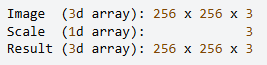


Cuando una de las dimensiones comparadas es uno, se utiliza la otra. En otras palabras, las dimensiones con tamaño 1 se estiran o "copian" para coincidir con la otra.

En el siguiente ejemplo, tanto los arrays A como B tienen ejes con longitud uno que se expanden a un tamaño más grande durante la operación de broadcasting:

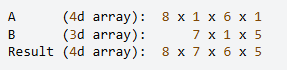

#### Arrays Broadcastables

Un conjunto de arrays se llama "broadcastable" a la misma forma si las reglas anteriores producen un resultado válido.

Por ejemplo, si a.shape es (5,1), b.shape es (1,6), c.shape es (6,) y d.shape es () (es decir, d es un escalar), entonces a, b, c y d son todos broadcastables a la dimensión (5,6); y:

a actúa como un array (5,6) donde a[:,0] se broadcast a las otras columnas,
b actúa como un array (5,6) donde b[0,:] se broadcast a las otras filas,
c actúa como un array (1,6) y, por lo tanto, como un array (5,6) donde c[:] se broadcast a cada fila, y finalmente,
d actúa como un array (5,6) donde el único valor se repite.
Aquí hay algunos ejemplos más:

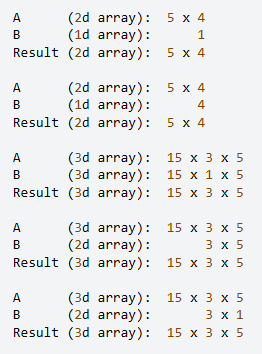

Ejemplos de Formas que No Hacen Broadcasting:

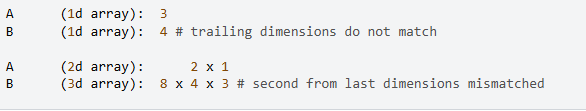

Ejemplo de Broadcasting cuando un Array 1-d se Suma a un Array 2-d:



In [4]:
a = np.array([[ 0.0,  0.0,  0.0],
              [10.0, 10.0, 10.0],
              [20.0, 20.0, 20.0],
              [30.0, 30.0, 30.0]])
b = np.array([1.0, 2.0, 3.0])
print(a + b)

[[ 1.  2.  3.]
 [11. 12. 13.]
 [21. 22. 23.]
 [31. 32. 33.]]


In [5]:
b = np.array([1.0, 2.0, 3.0, 4.0])
print(a + b)
# Traceback (most recent call last):
# ValueError: operands could not be broadcast together with shapes (4,3) (4,)


ValueError: operands could not be broadcast together with shapes (4,3) (4,) 

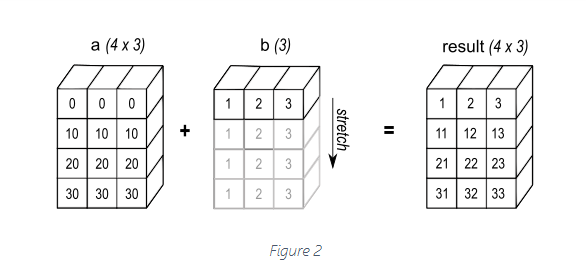                       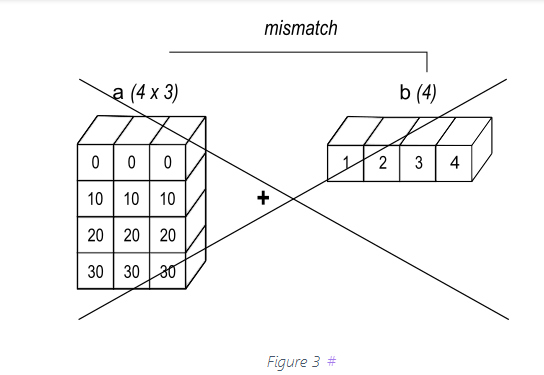

Como se muestra en la Figura 2, b se suma a cada fila de a. En la Figura 3, se genera una excepción debido a las formas incompatibles.

Ejemplo de Producto Externo:
Broadcasting proporciona una forma conveniente de tomar el producto externo (u otra operación externa) de dos arrays. El siguiente ejemplo muestra una operación de suma externa de dos arrays 1-d:

In [6]:
a = np.array([0.0, 10.0, 20.0, 30.0])
b = np.array([1.0, 2.0, 3.0])
print(a[:, np.newaxis] + b)



[[ 1.  2.  3.]
 [11. 12. 13.]
 [21. 22. 23.]
 [31. 32. 33.]]


En algunos casos, el broadcasting estira ambos arrays para formar un array de salida más grande que cualquiera de los arrays iniciales. Aquí, el operador newaxis inserta un nuevo eje en a, convirtiéndolo en un array bidimensional 4x1. Combinando el array 4x1 con b, que tiene forma (3,), se obtiene un array 4x3

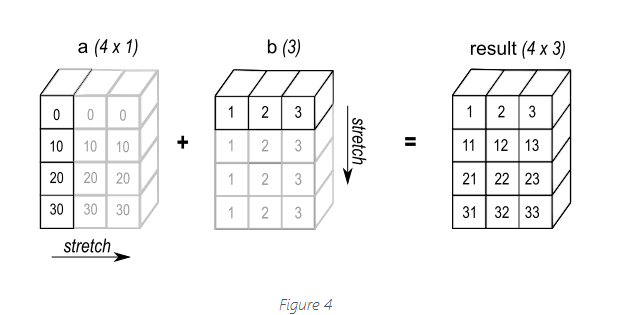

### Ejemplo Práctico: Cuantificación Vectorial

El broadcasting aparece con bastante frecuencia en problemas del mundo real. Un ejemplo típico ocurre en el algoritmo de cuantificación vectorial (VQ) utilizado en teoría de la información, clasificación y otras áreas relacionadas. La operación básica en VQ encuentra el punto más cercano en un conjunto de puntos, llamados códigos en la jerga de VQ, a un punto dado, llamado la observación. En el caso muy simple, bidimensional mostrado a continuación, los valores en la observación describen el peso y la altura de un atleta a clasificar. Los códigos representan diferentes clases de atletas. Encontrar el punto más cercano requiere calcular la distancia entre la observación y cada uno de los códigos. La distancia más corta proporciona la mejor coincidencia. En este ejemplo, codes[0] es la clase más cercana, lo que indica que el atleta probablemente sea un jugador de baloncesto.

In [7]:
from numpy import array, argmin, sqrt, sum
observation = array([111.0, 188.0])
codes = array([[102.0, 203.0],
               [132.0, 193.0],
               [45.0, 155.0],
               [57.0, 173.0]])
diff = codes - observation    # el broadcasting ocurre aquí
dist = sqrt(sum(diff**2,axis=-1))
print(argmin(dist))  # Salida: 0


0


En este ejemplo, el array observation se estira para coincidir con la forma del array codes:

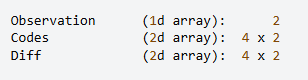

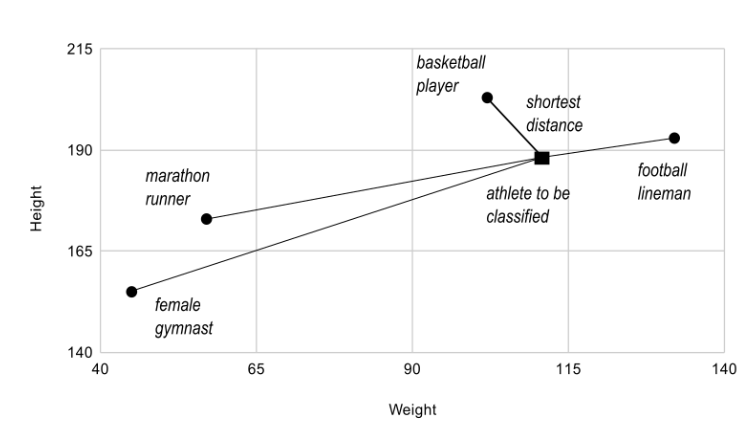

En un caso práctico, la operación básica de cuantificación vectorial calcula la distancia entre un objeto a clasificar (el cuadrado oscuro) y múltiples códigos conocidos (los círculos grises). En este caso simple, los códigos representan clases individuales. Los casos más complejos usan múltiples códigos por clase.

Típicamente, un gran número de observaciones, tal vez leídas de una base de datos, se comparan con un conjunto de códigos. Considera este escenario:




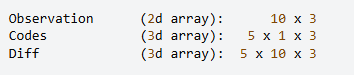

El array tridimensional diferencia es una consecuencia del broadcasting, no una necesidad para el cálculo. Los grandes conjuntos de datos generarán un gran array intermedio que es ineficiente computacionalmente. En su lugar, si cada observación se calcula individualmente usando un bucle de Python alrededor del código en el ejemplo bidimensional anterior, se usa un array mucho más pequeño.

El broadcasting es una herramienta poderosa para escribir código corto y generalmente intuitivo que realiza sus cálculos de manera muy eficiente en C. Sin embargo, hay casos en los que el broadcasting usa cantidades innecesariamente grandes de memoria para un algoritmo en particular. En estos casos, es mejor escribir el bucle externo del algoritmo en Python. Esto también puede producir código más legible, ya que los algoritmos que usan broadcasting tienden a volverse más difíciles de interpretar a medida que aumenta el número de dimensiones en el broadcast.